# Final Project

1. EDA
2. SVM

## 1. EDA

In [33]:
# packages
library(dplyr)
library(tidyverse)
library(ggplot2)
library(ggpubr)
library(e1071)
library(ROCR)

In [34]:
# data loading
data <- read.csv("hcv.csv") %>% 
               # delete id
               select(-X) %>%
               # remove "0s=suspect Blood Donor"
                filter(Category != "0s=suspect Blood Donor") %>%
                mutate(Category = case_when(Category == "0=Blood Donor" ~ "BD",
                                            Category == "1=Hepatitis" ~ "H",
                                            Category == "2=Fibrosis" ~ "F",
                                            Category == "3=Cirrhosis" ~ "C"),
                       Category = as.factor(Category),
                       Sex = as.factor(ifelse(Sex == "m", 0, 1))) %>% 
                na.omit()

In [35]:
head(data)

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
,<fct>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,BD,32,0,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106,12.1,69.0
2,BD,32,0,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74,15.6,76.5
3,BD,32,0,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86,33.2,79.3
4,BD,32,0,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80,33.8,75.7
5,BD,32,0,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76,29.9,68.7
6,BD,32,0,41.6,43.3,18.5,19.7,12.3,9.92,6.05,111,91.0,74.0


In [36]:
table(data$Category)


 BD   C   F   H 
526  24  12  20 

Very imbalanced sample sizes among all groups of HCV staging.

In [37]:
# summary of this dataset
summary(data)

 Category      Age       Sex          ALB             ALP        
 BD:526   Min.   :23.0   0:357   Min.   :23.00   Min.   : 11.30  
 C : 24   1st Qu.:39.0   1:225   1st Qu.:39.00   1st Qu.: 52.50  
 F : 12   Median :47.0           Median :41.95   Median : 66.00  
 H : 20   Mean   :47.3           Mean   :41.83   Mean   : 67.65  
          3rd Qu.:54.0           3rd Qu.:45.17   3rd Qu.: 79.30  
          Max.   :77.0           Max.   :82.20   Max.   :416.60  
      ALT              AST              BIL              CHE        
 Min.   :  0.90   Min.   : 12.00   Min.   :  1.80   Min.   : 1.420  
 1st Qu.: 16.32   1st Qu.: 21.43   1st Qu.:  5.30   1st Qu.: 6.950  
 Median : 22.50   Median : 25.60   Median :  7.15   Median : 8.265  
 Mean   : 25.67   Mean   : 33.33   Mean   : 11.09   Mean   : 8.212  
 3rd Qu.: 31.75   3rd Qu.: 31.60   3rd Qu.: 11.00   3rd Qu.: 9.565  
 Max.   :118.10   Max.   :324.00   Max.   :209.00   Max.   :16.410  
      CHOL            CREA              GGT            

### EDA - Continuous Variables

In [38]:
# extract only continuous variables & category
continuous <- data %>%
                select_if(is.numeric)
continuous <- cbind(continuous, Category = data[,1])

# arrays for boxplots
bps <- vector("list", ncol(continuous)-1)

In [39]:
# produce boxplots
for(i in 1:(ncol(continuous)-1)){
    bp <- continuous[,c(i, ncol(continuous))]
    var <- colnames(bp)[1]
    liver_bp <- continuous[,c(i, ncol(continuous))] %>%
                        gather(key = "variables", value = "value", -Category)

    bps[[i]] <- ggplot(data = liver_bp) + 
                    geom_boxplot(aes(x = Category, y = value)) + 
                    facet_wrap(~ variables, scales = "free", nrow = 1) +
                    labs(x = "Staging", y = var) + theme_bw() +
                    ggtitle(paste0("Boxplot of ", var, "and Staging", sep = "")) +
                    theme(plot.title = element_text(hjust=.5, size=6))
}

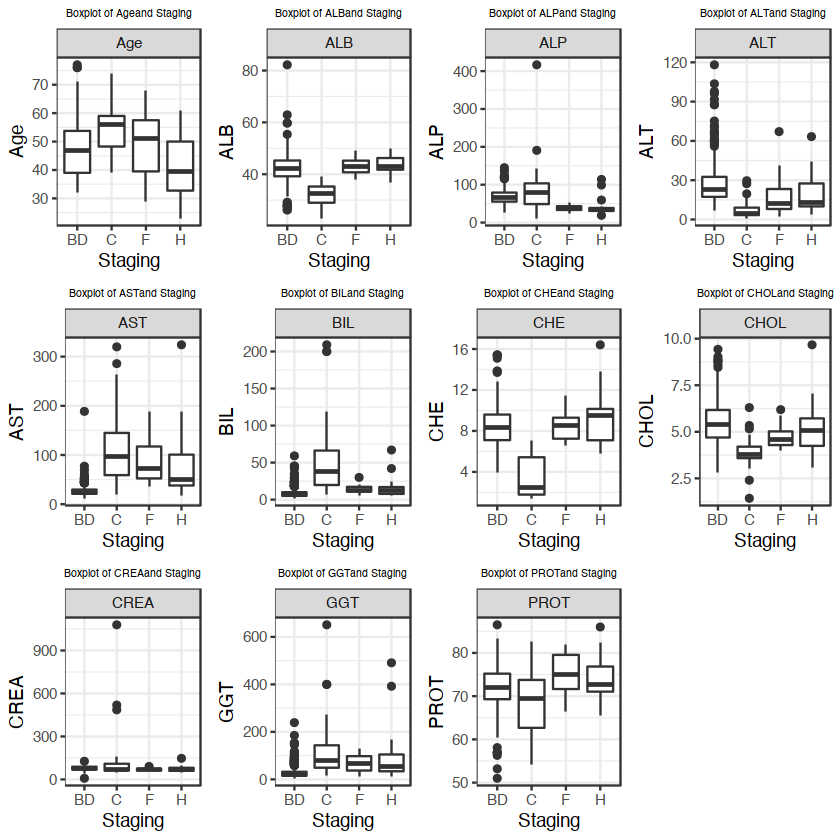

In [40]:
# plot boxplots
options(reper.plot.width = 21, reper.plot.height = 21)
ggarrange(plotlist = bps[1:11], ncol = 4, nrow = 3)

In [41]:
# # take log for some variables
# bps_2 <- vector("list", ncol(continuous)-1)

# for(i in 1:(ncol(continuous)-1)){
    
#     if(i %in% c(2,3,6,9,10)){
#         data <- continuous[,c(i, ncol(continuous))]
#         data[,1] = log(data[,1])
#     }else{
#         data <- continuous[,c(i, ncol(continuous))]
#     } 
#      var <- colnames(data)[1]
#      liver_bp <- data %>% gather(key = "variables", value = "value", -outcome)

#      bps_2[[i]] <- ggplot(data = liver_bp) + 
#                          geom_boxplot(aes(x = outcome, y = value)) + 
#                          labs(x = "Staging", y = var) + theme_bw() +
#                          ggtitle(paste0("Boxplot of ", var, "and Staging", sep = "")) +
#                          theme(plot.title = element_text(hjust=.5, size=15))
# }

## Support Vector Machine

As we did in hw, we are going to use three different kernels for support vector machine classify the level of `staging` of a subject in this analysis. They are `Linear`, `Radial`, and `Polynomial`. We will first split the whole data set into training and test data. We will use 70% of the whole data for training models.

We will try three different ways:

1) Weighting each class when tuning

2) Using SMOTE data

3) Using weighted SMOTE data

If I have time, I will try **ordinal logistic regression**.

In [42]:
library(dplyr)
# load data
train_x = read.csv("train_x.csv")
train_labels = read.csv("train_labels.csv") %>%
                transmute(Category = case_when(V1 == 0 ~ "BD",
                                               V1 == 1 ~ "H",
                                               V1 == 2 ~ "F",
                                               V1 == 3 ~ "C")) %>%
                mutate(Category = as.factor(Category))

test_x = read.csv("test_x.csv")
test_labels = read.csv("test_labels.csv") %>% 
                    transmute(Category = case_when(V1 == 0 ~ "BD",
                                                   V1 == 1 ~ "H",
                                                   V1 == 2 ~ "F",
                                                   V1 == 3 ~ "C")) %>%
                    mutate(Category = as.factor(Category))   
# train & test data
train = data.frame(train_labels, train_x)
test = data.frame(test_labels, test_x)

## Outlier detection using SVM

We will use `kernlab` package to find outliers.

In [43]:
#library(kernlab)

In [44]:
#kernlab::ksvm(train, nu=0.09, type="one-svc", kernel=)

In [45]:
#get_index=predict(svm_model)
#head(get_index)

In [46]:
#out_index=which(get_index[,1]==TRUE)
#train[out_index]

In [47]:
# class weights
round((nrow(train))/(table(train$Category)*4),1)


 BD   C   F   H 
0.3 5.1 7.2 6.3 

In [69]:
# initial settings
kernels <- c('linear', 'radial', 'polynomial')
cost0 <- 10^(seq(-2, 2, 0.1))
gamma0 <- 10^(seq(-5, 5, 0.1))
degree0 <- c(1, 2, 3, 4, 5)
CW <- c('BD' = 0.3, 'C' = 5.1, 'F' = 7.2, 'H' = 6.3)

# vector of lists to store tuning results
tune_result <- vector('list', 3)

In [70]:
# tuning all models with different kernels
for(i in 1:length(kernels)){
  # reproducability
    set.seed(503)
    if(kernels[i] == 'linear'){
        tune_result[[i]] = tune(svm, Category ~ ., data = train, kernel = kernels[i],
                                scale = FALSE, range = list(cost = cost0),
                                class.weights = CW, tunecontrol = tune.control(cross = 5))
    }else if(kernels[i] == 'radial'){
        tune_result[[i]] = tune(svm, Category ~ ., data = train, kernel = kernels[i],
                                scale = FALSE, range = list(cost = cost0, gamma = gamma0),
                                class.weights = CW, tunecontrol = tune.control(cross = 5))
    }else{
        tune_result[[i]] = tune(svm, Category ~ ., data = train, kernel = kernels[i],
                                scale = FALSE, range = list(cost = cost0, degree = degree0),
                                class.weights = CW, tunecontrol = tune.control(cross = 5))
    }
}

### Best models for each kernel

In [76]:
# vector of lists to store svm results
best.models <- vector('list', 3)

for(i in 1:length(kernels)){
    hyper = tune_result[[i]]$best.parameters
    if(kernels[i] == 'linear'){
        best.models[[i]] <- svm(Category ~ ., data = train, kernel = kernels[i], 
                                scale = FALSE, cost = hyper[,1], class.weights = CW)
    }else if(kernels[i] == 'radial'){
        best.models[[i]] <- svm(Category ~ ., data = train, kernel = kernels[i], 
                                scale = FALSE, cost = hyper[,1], gamma = hyper[,2],
                                class.weights = CW)
    }else{
        best.models[[i]] <- svm(Category ~ ., data = train, kernel = kernels[i], 
                                scale = FALSE, cost = hyper[,1], degree = hyper[,2],
                                class.weights = CW)
    }
}

In [77]:
# Prediction & Confusion Matrix: Training dataset
results <- vector('list', length(kernels))
for(i in 1:length(kernels)){
    # array to store results for each model
    a <- array(list(), 2)
    # training data
    ## prediction
    pred = predict(best.models[[i]], train[, -1])
    ## confusion matrix
    confusion = table(predict = pred, truth = train$Category)
    ## overall error
    overall = mean(pred == train$Category)
    ## error for each class
    each.class = round(diag(confusion)/table(train$Category), 2)
    a[[1]] <- list(pred = pred, confusion = confusion, overall = overall, 
                   recall.each.class = each.class)
    # test data
    ## prediction
    pred = predict(best.models[[i]], test[, -1])
    ## confusion matrix
    confusion = table(truth = test$Category, predict = pred)
    ## overall error
    accuracy = mean(pred == test$Category)
    ## recall for each class
    recall = round(diag(confusion)/table(test$Category), 2)
    ## precision for each class
    precision = round(diag(confusion)/table(pred),2)
    a[[2]] <- list(pred = pred, confusion = confusion, accuracy = accuracy, 
                   recall = recall, precision = precision)
    
    # combine training & test results into 'results' list
    results[[i]] <- a
}

## Results for training

In [73]:
# results[[3]][[2]][2:5]
# print("---------------SMOTE")
# #results.wSMOTE[[3]][[2]][2:5]

In [74]:
#results[[1]][[1]][2:4]; results[[2]][[1]][2:4]; results[[3]][[1]][2:4]

## Results for test

In [116]:
#results[[1]][[2]][3:4]; results[[2]][[2]][3:4]; results[[3]][[2]][3:4]

## SVM with SMOTE

In [55]:
# # train dataset : SMOTE
# train.x.SMOTE = read.csv("X_train_SMOTE.csv") %>% select(-X)
# train.labels.SMOTE = read.csv("Y_train_SMOTE.csv") %>% 
#                         transmute(Category = case_when(V1 == 0 ~ "BD",
#                                                        V1 == 1 ~ "H",
#                                                        V1 == 2 ~ "F",
#                                                        V1 == 3 ~ "C")) %>%
#                         mutate(Category = as.factor(Category))  
# train.SMOTE = data.frame(train.labels.SMOTE, train.x.SMOTE)

In [56]:
# # vector of lists to store tuning results
# tune_result.SMOTE <- vector('list', 3)

# # tuning all models with different kernels
# for(i in 1:length(kernels)){
#   # reproducability
#     set.seed(503)
#     if(kernels[i] == 'linear'){
#         tune_result.SMOTE[[i]] = tune(svm, Category ~ ., data = train.SMOTE, 
#                                       kernel = kernels[i], scale = FALSE, 
#                                       range = list(cost = cost0),
#                                       tunecontrol = tune.control(cross = 5))
#     }else if(kernels[i] == 'radial'){
#         tune_result.SMOTE[[i]] = tune(svm, Category ~ ., data = train.SMOTE, 
#                                       kernel = kernels[i],
#                                       scale = FALSE, range = list(cost = cost0, 
#                                                                   gamma = gamma0),
#                                       tunecontrol = tune.control(cross = 5))
#     }else{
#         tune_result.SMOTE[[i]] = tune(svm, Category ~ ., data = train.SMOTE, 
#                                       kernel = kernels[i],
#                                       scale = FALSE, range = list(cost = cost0, 
#                                                                   degree = degree0),
#                                       tunecontrol = tune.control(cross = 5))
#     }
# }

In [57]:
# # vector of lists to store svm results
# best.models.SMOTE <- vector('list', 3)

# for(i in 1:length(kernels)){
#     hyper = tune_result.SMOTE[[i]]$best.parameters
#     if(kernels[i] == 'linear'){
#         best.models.SMOTE[[i]] <- svm(Category ~ ., data = train.SMOTE, probability = TRUE,
#                                       kernel = kernels[i], scale = FALSE, cost = hyper[,1])
#     }else if(kernels[i] == 'radial'){
#         best.models.SMOTE[[i]] <- svm(Category ~ ., data = train.SMOTE, probability = TRUE,
#                                       kernel = kernels[i], scale = FALSE, 
#                                       cost = hyper[,1], gamma = hyper[,2])
#     }else{
#         best.models.SMOTE[[i]] <- svm(Category ~ ., data = train.SMOTE, probability = TRUE,
#                                       kernel = kernels[i], scale = FALSE, 
#                                       cost = hyper[,1], degree = hyper[,2])
#     }
# }

In [58]:
# # Prediction & Confusion Matrix: Training dataset
# results.SMOTE <- vector('list', length(kernels))
# for(i in 1:length(kernels)){
#     # array to store results for each model
#     a <- array(list(), 2)
#     # training data
#     ## prediction
#     pred = predict(best.models.SMOTE[[i]], train.SMOTE[, -1])
#     ## confusion matrix
#     confusion = table(predict = pred, truth = train.SMOTE$Category)
#     ## overall error
#     overall = mean(pred == train.SMOTE$Category)
#     ## error for each class
#     each.class = round(diag(confusion)/table(train.SMOTE$Category), 2)
#     a[[1]] <- list(pred = pred, confusion = confusion, overall = overall, 
#                    recall.each.class = each.class)
#     # test data
#     ## prediction
#     pred = predict(best.models.SMOTE[[i]], test[, -1])
#     ## confusion matrix
#     confusion = table(truth = test$Category, predict = pred)
#     ## overall error
#     overall = mean(pred == test$Category)
#     ## error for each class
#     each.class = round(diag(confusion)/table(test$Category), 2)
#     a[[2]] <- list(pred = pred, confusion = confusion, overall = overall, 
#                    recall.each.class = each.class)
    
#     # combine training & test results into 'results' list
#     results.SMOTE[[i]] <- a
# }

In [59]:
#results.SMOTE[[1]][[1]][3:4]; results.SMOTE[[2]][[1]][3:4]; results.SMOTE[[3]][[1]][3:4]

In [60]:
# results.SMOTE[[1]][[2]][3:4]; results.SMOTE[[2]][[2]][3:4]; results.SMOTE[[3]][[2]][3:4]

# Weighted SMOTE --- This section is for the best radial kernel model

In [61]:
# change the file name to "X_train_wSMOTE.csv"
train.x.wSMOTE = read.csv("X_train_wSMOTE.csv")
head(train.x.wSMOTE)

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,32,0,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74,15.6,76.5
2,32,0,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86,33.2,79.3
3,32,0,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80,33.8,75.7
4,32,0,42.2,41.9,35.8,31.1,16.1,5.82,4.60,109,21.5,67.1
5,32,0,44.3,52.3,21.7,22.4,17.2,4.15,3.57,78,24.1,75.4
6,33,0,36.3,78.6,23.6,22.0,7.0,8.56,5.38,78,19.4,68.7


In [62]:
# train dataset : SMOTE
train.x.wSMOTE = read.csv("X_train_wSMOTE.csv")
train.labels.wSMOTE = read.csv("Y_train_wSMOTE.csv") %>% 
                        transmute(Category = case_when(V1 == 0 ~ "BD",
                                                       V1 == 1 ~ "H",
                                                       V1 == 2 ~ "F",
                                                       V1 == 3 ~ "C")) %>%
                        mutate(Category = as.factor(Category))  
train.wSMOTE = data.frame(train.labels.wSMOTE, train.x.wSMOTE)

In [80]:
# vector of lists to store tuning results
tune_result.wSMOTE <- vector('list', 3)

# tuning all models with different kernels
for(i in 1:length(kernels)){
  # reproducability
    set.seed(503)
    if(kernels[i] == 'linear'){
        tune_result.wSMOTE[[i]] = tune(svm, Category ~ ., data = train.wSMOTE, 
                                      kernel = kernels[i], scale = FALSE, 
                                      range = list(cost = cost0),
                                      tunecontrol = tune.control(cross = 5))
    }else if(kernels[i] == 'radial'){
        tune_result.wSMOTE[[i]] = tune(svm, Category ~ ., data = train.wSMOTE, 
                                      kernel = kernels[i],
                                      scale = FALSE, range = list(cost = cost0, 
                                                                  gamma = gamma0),
                                      tunecontrol = tune.control(cross = 5))
    }else{
        tune_result.wSMOTE[[i]] = tune(svm, Category ~ ., data = train.wSMOTE, 
                                      kernel = kernels[i],
                                      scale = FALSE, range = list(cost = cost0, 
                                                                  degree = degree0),
                                      tunecontrol = tune.control(cross = 5))
    }
}

In [81]:
# vector of lists to store svm results
best.models.wSMOTE <- vector('list', 3)

for(i in 1:length(kernels)){
    hyper = tune_result.wSMOTE[[i]]$best.parameters
    if(kernels[i] == 'linear'){
        best.models.wSMOTE[[i]] <- svm(Category ~ ., data = train.wSMOTE, probability = TRUE,
                                      kernel = kernels[i], scale = FALSE, cost = hyper[,1])
    }else if(kernels[i] == 'radial'){
        best.models.wSMOTE[[i]] <- svm(Category ~ ., data = train.wSMOTE, probability = TRUE,
                                      kernel = kernels[i], scale = FALSE, 
                                      cost = hyper[,1], gamma = hyper[,2])
    }else{
        best.models.wSMOTE[[i]] <- svm(Category ~ ., data = train.wSMOTE, probability = TRUE,
                                      kernel = kernels[i], scale = FALSE, 
                                      cost = hyper[,1], degree = hyper[,2])
    }
}

In [82]:
# Prediction & Confusion Matrix: Training dataset
results.wSMOTE <- vector('list', length(kernels))
for(i in 1:length(kernels)){
    # array to store results for each model
    a <- array(list(), 2)
    # training data
    ## prediction
    pred = predict(best.models.wSMOTE[[i]], train.wSMOTE[, -1])
    ## confusion matrix
    confusion = table(predict = pred, truth = train.wSMOTE$Category)
    ## overall error
    overall = mean(pred == train.wSMOTE$Category)
    ## error for each class
    each.class = round(diag(confusion)/table(train.wSMOTE$Category), 2)
    a[[1]] <- list(pred = pred, confusion = confusion, overall = overall, 
                   recall.each.class = each.class)
    # test data
    ## prediction
    pred = predict(best.models.wSMOTE[[i]], test[, -1])
    ## confusion matrix
    confusion = table(truth = test$Category, predict = pred)
    ## overall error
    accuracy = mean(pred == test$Category)
    ## recall for each class
    recall = round(diag(confusion)/table(test$Category), 2)
    ## precision for each class
    precision = round(diag(confusion)/table(pred),2)
    a[[2]] <- list(pred = pred, confusion = confusion, accuracy = accuracy, 
                   recall = recall, precision = precision)
    
    # combine training & test results into 'results' list
    results.wSMOTE[[i]] <- a
}

In [115]:
#results.wSMOTE[[2]][[2]][2:5]

$confusion
     predict
truth  BD   C   F   H
   BD 160   0   0   2
   C    0   7   2   0
   F    1   1   3   1
   H    1   0   1   5

$accuracy
[1] 0.951087

$recall

  BD    C    F    H 
0.99 0.78 0.50 0.71 

$precision
pred
  BD    C    F    H 
0.99 0.88 0.50 0.62 


In [67]:
# training result
#results.wSMOTE[[1]][[1]][2:4]; results.wSMOTE[[2]][[1]][2:4]; results.wSMOTE[[3]][[1]][2:4]
# test result
#results.wSMOTE[[1]][[2]][3:4]; results.wSMOTE[[2]][[2]][3:4]; results.wSMOTE[[3]][[2]][3:4]

$accuracy
[1] 0.9130435

$recall

  BD    C    F    H 
0.99 0.44 0.17 0.43 


$accuracy
[1] 0.8804348

$recall

BD  C  F  H 
 1  0  0  0 


$accuracy
[1] 0.9130435

$recall

  BD    C    F    H 
0.99 0.44 0.17 0.43 


# Results of all models

![t](image.png)

![recall](recall.png)

In [83]:
# overall
# weighted: 0.9456522
# SMOTE: 0.9402174
# weighted SMOTE: 0.9293478

# tables
all <- matrix(rep(0, 24),  6, 4, byrow=TRUE)
colnames(all) <- c('BD', 'C', 'F', 'H')
rownames(all) <- c('weighted-linear', 'weighted-radial', 'weighted-polynomial',
                   #'SMOTE-linear', 'SMOTE-radial', 'SMOTE-polynomial',
                   'weightedSMOTE-linear', 'weightedSMOTE-radial', 'weightedSMOTE-plynomial')
all[1,]<-unlist(results[[1]][[2]][4]);all[2,]<-unlist(results[[2]][[2]][4]);all[3,]<-unlist(results[[3]][[2]][4])
#all[4,]<-unlist(results.SMOTE[[1]][[2]][4]);all[5,]<-unlist(results.SMOTE[[2]][[2]][4]);all[6,]<-unlist(results.SMOTE[[3]][[2]][4])
all[4,]<-unlist(results.wSMOTE[[1]][[2]][4]);all[5,]<-unlist(results.wSMOTE[[2]][[2]][4]);all[6,]<-unlist(results.wSMOTE[[3]][[2]][4])
all
recall

,BD,C,F,H
weighted-linear,0.98,0.44,0.33,0.43
weighted-radial,0.96,0.56,0.33,0.71
weighted-polynomial,0.96,0.33,0.33,0.43
weightedSMOTE-linear,0.99,0.44,0.17,0.43
weightedSMOTE-radial,0.99,0.78,0.50,0.71
weightedSMOTE-plynomial,0.99,0.44,0.17,0.43


We want to get the best performance on C. SVM with polynomial kernel with weighted tuning and SVM with polynomial kernel with weighted SMOTE data. For other classes, **SVM with weighted polynomial has the best recall**.

# Ordinal Logistic Regression

In [85]:
library(foreign)
library(ggplot2)
library(MASS)
library(Hmisc)
library(reshape2)

In [110]:
train.new = train.wSMOTE %>% filter(ALP < 100, ALT < 50, AST < 100, BIL < 150, CREA < 500, GGT < 100)

In [113]:
# we might have outliers
m <- polr(Category ~ ., data = train.new, Hess=TRUE, method = "logistic")
prediction.result <- predict(m, test[,-1])
mean(prediction.result == test$Category)
confusion = table(truth = test$Category, predict = prediction.result)
recall = round(diag(confusion)/table(test$Category), 2)
precision = round(diag(confusion)/table(prediction.result),2)
recall; precision

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] 0.9021739


  BD    C    F    H 
0.98 0.11 0.17 0.71 

prediction.result
  BD    C    F    H 
0.97 0.17 0.33 0.45 

# ROC Curves: SMOTE

In [101]:
# library(e1071)
# svm.smote.prob <- vector('list', 3)
# ROC <- vector('list', 4)

# category <- vector("list", 4)
# variable <- c("BD", "H", "F", "C")
# for(i in 1:4){
#     category[[i]] <- data.frame(Category = test$Category) %>% 
#                         mutate(Category = ifelse(Category == variable[i], 1, 0))}

In [102]:
# # ROC
# ROCs <- vector('list', 4)
# # auc
# auc <- data.frame(matrix(rep(0, 12), 3, 4, byrow = TRUE))
# colnames(auc) <- c('BD', 'H', 'F', 'C')
# rownames(auc) <- c('SVM(linear)', 'SVM(radial)', 'SVM(polynomial)')

# for(i in 1:4){
#     for(j in 1:3){
#         # fit each model to each class
#         svm.smote = best.models.SMOTE[[j]]
#         svm.smote.prob = predict(svm.smote, newdata = test[,-1], 
#                                  type = 'prob', probability = TRUE)
#         # ROC
#         rocr = prediction(attr(svm.smote.prob, "probabilities")[,i], category[[i]])
#         perf = performance(rocr, "tpr", "fpr")
        
#         # AUC
#         auc[j,i] = performance(rocr, "auc")@y.values
        
#         # plots
#         if(j == 1){
#             ROC = plot(perf, col = j+1, main = paste("ROC curve for", variable[i]))
#         }else{
#             ROC = plot(perf, col = j+1, add = TRUE)
#         }
#         legend(0.6, 0.6, c('SVM(linear)', 'SVM(radial)', 'SVM(polynomial)'), 2:5)
#     }
#     ROCs[[i]] <- ROC
# }